In [1]:

import torch

from editing_diffusion.llm_objects import spot_objects
from editing_diffusion.detectors.owlvitv2 import OWLViTv2Detector

device = torch.device("cuda:1")

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and tokenizer names
model_name = "google/gemma-7b-it" #"mistralai/Mistral-7B-Instruct-v0.1" #"google/gemma-7b-it" #"mistralai/Mistral-7B-Instruct-v0.1"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
model_params = {
    #"max_length": 1200,  # Maximum length of generated text
    "max_new_tokens": 200,
    #"temperature": 0.7,  # Controls randomness (higher -> more random)
    #"top_k": 50, 
}

In [4]:
prompts = [
    "a realistic cartoon-style image with a princess and four dwarfs",
    "a vivid photo with a woman on the right and a clown on the left walking in a dirty alley",
    "a monkey sitting above a green motorcycle on the left and another raccoon sitting above a blue motorcycle on the right",
    "a photo of a giant macaron and a croissant splashing in the Seine with the Eiffel Tower in the background",
    "a DSLR photo of a meatball and a donut falling from the clouds onto a neighborhood",
]
results = []
for prompt in prompts:
    result = spot_objects(tokenizer, model, prompt, device, **model_params)
    results.append(result)

In [5]:
results

[{'objects': [('princess', [None]), ('dwarf', [None, None, None, None])],
  'bg_prompt': 'A realistic cartoon-style image',
  'neg_prompt': ''},
 {'objects': [('woman', [None]), ('clown', [None]), ('alley', ['dirty'])],
  'bg_prompt': 'A photo',
  'neg_prompt': ''},
 {'objects': [('monkey', [None]),
   ('motorcycle', ['green']),
   ('raccoon', [None]),
   ('motorcycle', ['blue'])],
  'bg_prompt': 'Unknown',
  'neg_prompt': ''},
 {'objects': [('macaron', ['giant']),
   ('croissant', [None]),
   ('Eiffel Tower', [None])],
  'bg_prompt': 'A photo of the Seine River with the Eiffel Tower in the background',
  'neg_prompt': ''},
 {'objects': [('meatball', [None]),
   ('donut', [None]),
   ('neighborhood', [None])],
  'bg_prompt': 'A realistic neighborhood',
  'neg_prompt': ''}]

In [6]:
from diffusers import StableDiffusionXLPipeline

In [7]:
base = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [8]:
seed = 0

In [9]:
generator = torch.Generator(device=device).manual_seed(seed)
n_img=1

In [10]:

out = base(prompt=prompts[0], num_inference_steps=300, generator=generator)

  0%|          | 0/300 [00:00<?, ?it/s]

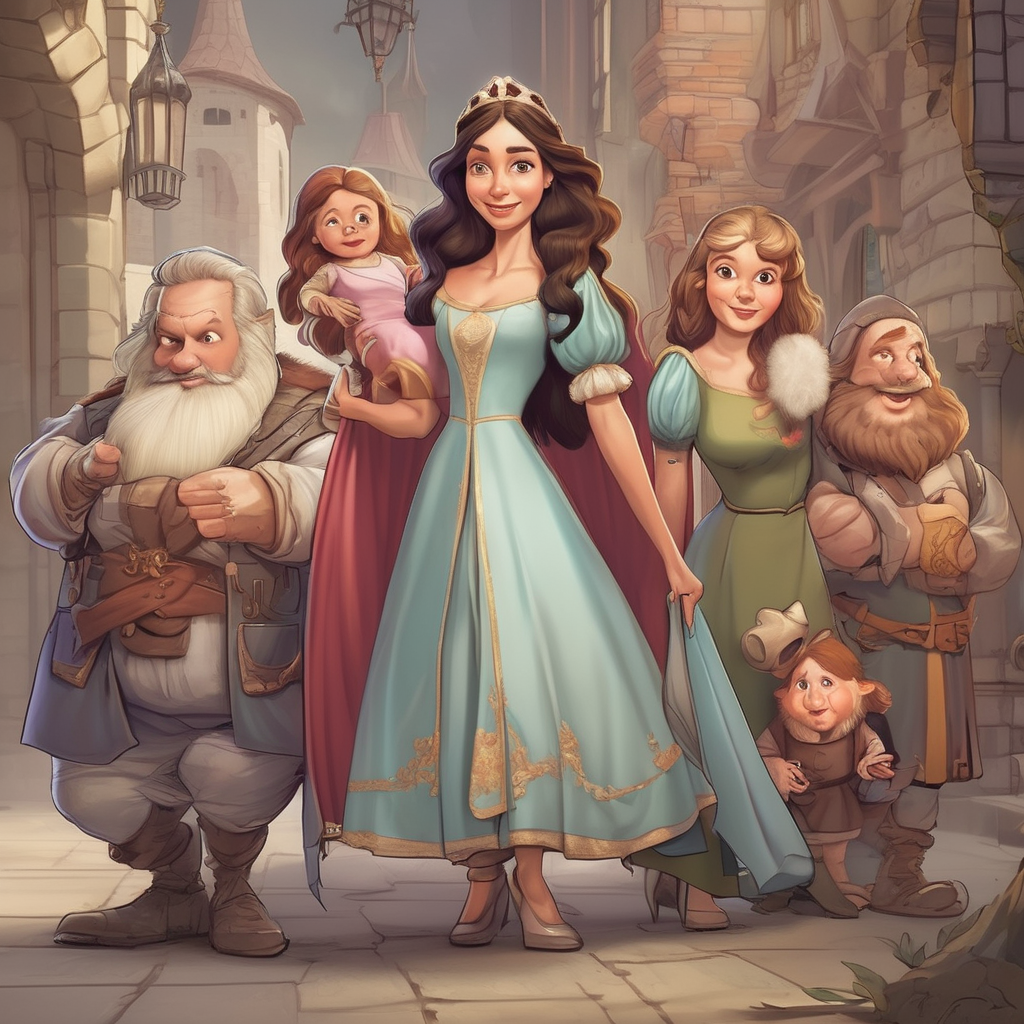

In [11]:
out.images[0]

In [12]:
detector = OWLViTv2Detector(device)

In [13]:
results_detection = detector(results[0]["objects"], out.images[0], device, 0.5, 0.3, 0.4)

In [14]:
results_detection

[('princess', [0.283, 0.082, 0.291, 0.83]),
 ('princess', [0.474, 0.218, 0.305, 0.751]),
 ('princess', [0.282, 0.163, 0.147, 0.246]),
 ('dwarf', [0.008, 0.238, 0.33, 0.616]),
 ('dwarf', [0.782, 0.274, 0.208, 0.491]),
 ('dwarf', [0.732, 0.597, 0.193, 0.31])]

In [15]:
width, height = out.images[0].size

In [16]:
from PIL import ImageDraw, ImageFont

In [17]:
img = out.images[0].copy()
draw = ImageDraw.Draw(img)
object_count = {}
for (name, box) in results_detection:
    x1, y1, w, h = box
    x2 = x1 + w
    y2 = y1 + h
    x1 *= width
    x2 *= width
    y1 *= height
    y2 *= height
    draw.rectangle(((int(x1), int(y1)), (int(x2), int(y2))), outline=(255, 0, 0))
    font = ImageFont.load_default(size=20)
    
    text_size = draw.textbbox((0, 0), f"{name}, id={object_count.get(name, 0)}", font=font)
    
    text_position = (x1, max(y1 - text_size[3] - 2, 0))
    draw.text(text_position, f"{name}, id={object_count.get(name, 0)}", fill='white', font=font)
    object_count[name] = object_count.get(name, 0) + 1


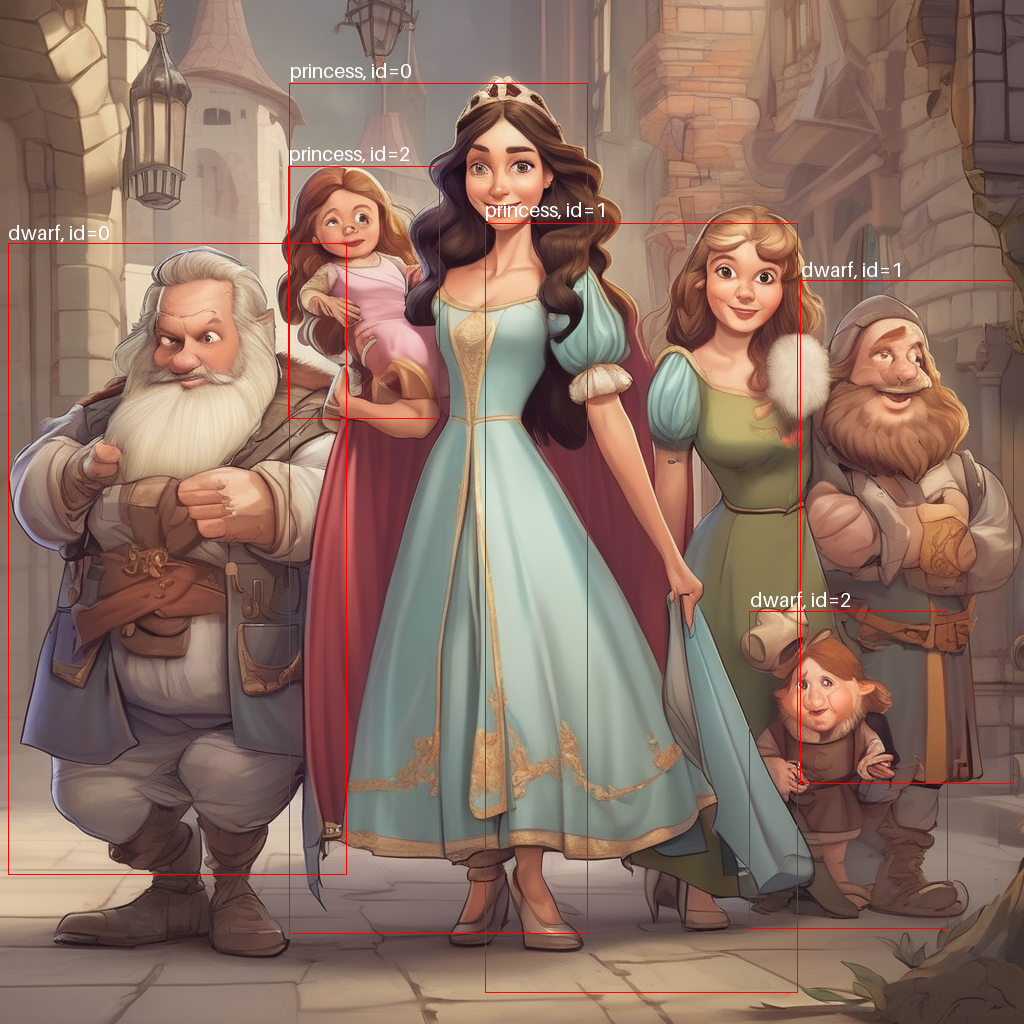

In [18]:
img